## Example for CMIP6

Here, CESM2 data serves as the training data, and the ML model trained on CESM2 data is applied to [CMIP6](https://www.wcrp-climate.org/wgcm-cmip/wgcm-cmip6) data.

Reference:     
- GitHub: https://github.com/NCAR/cesm2-le-aws    
- Data/Variables Information: 
    - https://ncar.github.io/cesm2-le-aws/model_documentation.html#data-catalog   
    - https://registry.opendata.aws/cmip6/   
- Reproduce CESM-LENS: https://github.com/NCAR/cesm2-le-aws/blob/main/notebooks/kay_et_al_lens2.ipynb    
- [Finding CMIP6 data using intake-esm and plotting time series for points](https://nbviewer.org/github/awslabs/amazon-asdi/blob/main/examples/cmip6/notebooks/cmip6_airtemperature.ipynb) by Zac Flamig

**Step 0: load necessary packages and define parameters (no need to change)**

In [1]:
%%time
# Display output of plots directly in Notebook
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import json
import intake
from flaml import AutoML
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
import util
import math
import seaborn as sns

with open("./config_cesm2_cmip6.json",'r') as load_f:
#     param = json.loads(json.load(load_f))
    param = json.load(load_f)
    
    model = param["model"] # cesm2
    urban_type = param["urban_type"] # md
    city_loc = param["city_loc"] # {"lat": 40.0150, "lon": -105.2705}
    l_component = param["l_component"]
    a_component = param["a_component"]
    experiment = param["experiment"]
    frequency = param["frequency"]
    cam_ls = param["cam_ls"]
    clm_ls = param["clm_ls"]
    forcing_variant = param["forcing_variant"]
    time = slice(param["time_start"],param["time_end"])
    member_id = param["member_id"]
    estimator_list = param["estimator_list"]
    time_budget = param["time_budget"]
    features = param["features"]
    label = param["label"]
    clm_var_mask = param["label"][0]
    CMIP6_url = param["CMIP6_url"]
    activity_id = param["activity_id"]
    experiment_id = param["experiment_id"]
    institution_id = param["institution_id"]
    table_id = param["table_id"]

CPU times: user 1.84 s, sys: 350 ms, total: 2.19 s
Wall time: 2.19 s


/glade/work/zhonghua/miniconda3/envs/aws_urban/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Step 1: load CESM2 data

In [2]:
# get a dataset
ds = util.get_data(model, city_loc, experiment, frequency, member_id, time, cam_ls, clm_ls,
                   forcing_variant=forcing_variant, urban_type=urban_type)
ds['time'] = ds.indexes['time'].to_datetimeindex()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


different lat between CAM and CLM subgrid info, adjust subgrid info's lat


**split into training and testing data**

In [3]:
mapping =  {
    "PRSN":"prsn", 
    "PRECT":"pr",
    "PSL":"psl",
    "TREFHT":"tas",
    "TREFHTMN":"tasmin",
    "TREFHTMX":"tasmax"
}

# create a dataframe
df = ds.to_dataframe().reset_index().dropna()
df["PRSN"] = (df["PRECSC"] + df["PRECSL"])*1000
df["PRECT"] = (df["PRECC"] + df["PRECL"])*1000

df_cesm = df.rename(columns=mapping)

# split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(
    df_cesm[features], df_cesm[label], test_size=0.1, random_state=42)
display(X_train.head())
display(y_train.head())

,pr,prsn,psl,tas,tasmax,tasmin
4253,5.120080e-05,1.210190e-18,102141.148438,297.131683,305.057770,291.910309
712,8.689989e-06,4.476514e-06,102655.820312,273.535492,277.919128,270.931824
4174,5.766846e-05,2.315565e-14,101171.445312,297.524048,305.175293,290.375336
1811,8.906457e-07,7.931703e-07,101316.953125,271.924591,277.630005,269.025482
5097,4.478946e-08,4.477884e-08,101735.164062,270.995270,275.632812,269.006317


,TREFMXAV
4253,305.300262
712,279.708527
4174,306.675201
1811,278.521729
5097,276.521973


### Step 2: load CMIP6 data

In [4]:
%%time
features = ['pr', 'prsn', 'psl','tas', 'tasmax', 'tasmin']

catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')
catalog_subset = catalog.search(
    activity_id=activity_id, 
    experiment_id=experiment_id, 
    institution_id=institution_id,
    variable_id=features,
    table_id=table_id
)
datasets = catalog_subset.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': True})
datasets


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


CPU times: user 8.71 s, sys: 973 ms, total: 9.69 s
Wall time: 17 s


{'ScenarioMIP.NOAA-GFDL.GFDL-ESM4.ssp370.day.gr1': <xarray.Dataset>
 Dimensions:    (bnds: 2, lat: 180, lon: 288, member_id: 1, time: 31390)
 Coordinates:
   * bnds       (bnds) float64 1.0 2.0
   * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
     lat_bnds   (lat, bnds) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
   * lon        (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
     lon_bnds   (lon, bnds) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
   * time       (time) object 2015-01-01 12:00:00 ... 2100-12-31 12:00:00
     time_bnds  (time, bnds) object dask.array<chunksize=(15695, 2), meta=np.ndarray>
   * member_id  (member_id) <U8 'r1i1p1f1'
     height     float64 2.0
 Data variables:
     pr         (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 592, 180, 288), meta=np.ndarray>
     prsn       (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 671, 180, 288), meta=np.ndarray>
     psl  

In [5]:
%%time
# define the dataset name in the dictionary and the "member_id"
df_cmip = datasets['ScenarioMIP.NOAA-GFDL.GFDL-ESM4.ssp370.day.gr1']\
          .sel(member_id = 'r1i1p1f1',
               time = slice(param["time_start"], param["time_end"]))\
          .sel(lat = param["city_loc"]["lat"], 
               lon = util.lon_to_360(param["city_loc"]["lon"]),
               method="nearest")\
          [features].load()\
          .to_dataframe().reset_index()
df_cmip.head()

CPU times: user 20.3 s, sys: 11 s, total: 31.3 s
Wall time: 18.5 s


,time,pr,prsn,psl,tas,tasmax,tasmin,lat,lon,member_id,height
0,2081-01-02 12:00:00,4.284881e-11,1.210498e-13,101005.351562,267.040985,274.020386,264.221344,40.5,254.375,r1i1p1f1,2.0
1,2081-01-03 12:00:00,1.998000e-06,6.424573e-07,100812.898438,272.238739,275.491943,270.209229,40.5,254.375,r1i1p1f1,2.0
2,2081-01-04 12:00:00,1.482927e-05,8.858435e-06,100455.796875,273.498535,274.920624,271.907166,40.5,254.375,r1i1p1f1,2.0
3,2081-01-05 12:00:00,6.613790e-06,5.915619e-06,101060.375000,271.265442,273.210297,269.065277,40.5,254.375,r1i1p1f1,2.0
4,2081-01-06 12:00:00,9.097347e-06,6.341099e-06,100795.867188,272.010651,276.695343,269.123260,40.5,254.375,r1i1p1f1,2.0


### Step 3: compare CESM2 training and CMIP6 data

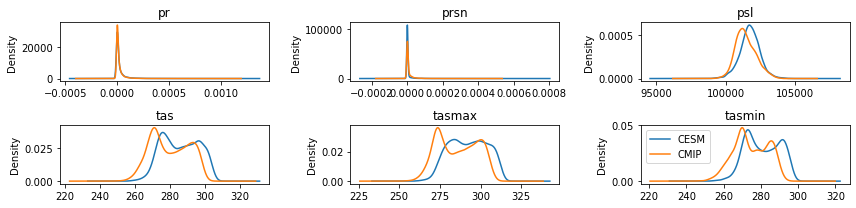

In [6]:
fig = plt.figure(figsize=(12,3))
idx = 1
for var in features:
    ax = fig.add_subplot(math.ceil(math.ceil(len(features)/3)), 3, idx)
    X_train[var].plot.kde(ax=ax, label="CESM")
    df_cmip[var].plot.kde(ax=ax, label="CMIP")
    idx+=1
    ax.set_title(var)
plt.legend()
plt.tight_layout()
plt.show()

### Step 4: automated machine learning

**train a model (emulator)**

In [7]:
%%time
# setup for automl
automl = AutoML()
automl_settings = {
    "time_budget": time_budget,  # in seconds
    "metric": 'r2',
    "task": 'regression',
    "estimator_list":estimator_list,
}

# train the model
automl.fit(X_train=X_train, y_train=y_train.values,
           **automl_settings, verbose=-1)
print(automl.model.estimator)

ExtraTreesRegressor(max_features=0.9591245274694429, max_leaf_nodes=426,
                    n_estimators=125, n_jobs=-1)
CPU times: user 2min 1s, sys: 2.9 s, total: 2min 4s
Wall time: 15.2 s


**evaluate the model**

In [8]:
y_pred = automl.predict(X_test)
print("root mean square error:",
      round(mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False),3))
print("r2:", 
      round(r2_score(y_true=y_test, y_pred=y_pred),3))

root mean square error: 0.636
r2: 0.997


**apply and test the machine learning model**      
use `automl.predict(X)` to apply the model

In [9]:
df_cmip[label] = automl.predict(df_cmip[features]).reshape(df_cmip.shape[0],-1)

### Step 5: visualization

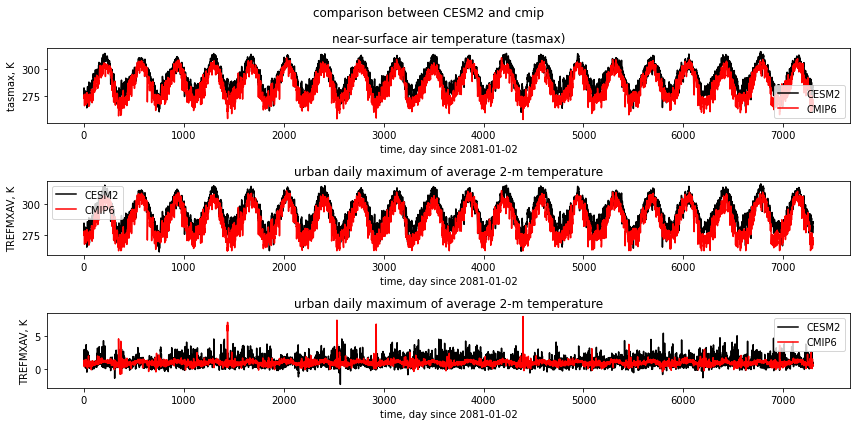

In [10]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,6))
fig.suptitle('comparison between CESM2 and cmip')
df_cesm["tasmax"].plot(label="CESM2",c="k",ax=ax1)
df_cmip["tasmax"].plot(label="cmip",c="r",ax=ax1)
ax1.set_title("near-surface air temperature (tasmax)")
ax1.set_ylabel("tasmax, K")
ax1.set_xlabel("time, day since 2081-01-02")
ax1.legend(["CESM2","CMIP6"])

df_cesm["TREFMXAV"].plot(label="CESM2",c="k",ax=ax2)
df_cmip["TREFMXAV"].plot(label="cmip",c="r",ax=ax2)
ax2.set_title("urban daily maximum of average 2-m temperature")
ax2.set_ylabel("TREFMXAV, K")
ax2.set_xlabel("time, day since 2081-01-02")
ax2.legend(["CESM2","CMIP6"])

(df_cesm["TREFMXAV"]-df_cesm["tasmax"]).plot(label="CESM2",c="k",ax=ax3)
(df_cmip["TREFMXAV"]-df_cmip["tasmax"]).plot(label="cmip",c="r",ax=ax3)
ax3.set_title("urban daily maximum of average 2-m temperature")
ax3.set_ylabel("TREFMXAV, K")
ax3.set_xlabel("time, day since 2081-01-02")
ax3.legend(["CESM2","CMIP6"])

plt.tight_layout()
plt.show()

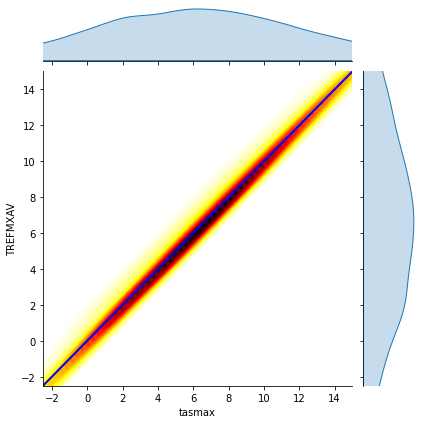

In [11]:
# reference: https://stackoverflow.com/questions/53964485/seaborn-jointplot-color-by-density
x = df_cesm["tasmax"]-df_cmip["tasmax"]
y = df_cesm["TREFMXAV"]-df_cmip["TREFMXAV"]

plot = sns.jointplot(x, y, kind="kde", cmap='hot_r', n_levels=60, fill=True)
plot.ax_joint.set_xlim(-2.5,15)
plot.ax_joint.set_ylim(-2.5,15)
plot.ax_joint.plot([-2.5,15], [-2.5,15], 'b-', linewidth = 2)
plt.show()

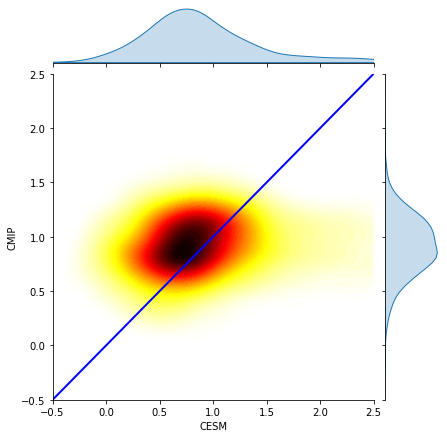

In [12]:
# reference: https://stackoverflow.com/questions/53964485/seaborn-jointplot-color-by-density
x = df_cesm["TREFMXAV"]-df_cesm["tasmax"]
y = df_cmip["TREFMXAV"]-df_cmip["tasmax"]

plot = sns.jointplot(x, y, kind="kde", cmap='hot_r', n_levels=60, fill=True)
plot.ax_joint.set_xlim(-0.5,2.5)
plot.ax_joint.set_ylim(-0.5,2.5)
plot.ax_joint.set_xlabel("CESM")
plot.ax_joint.set_ylabel("CMIP")
plot.ax_joint.plot([-0.5,2.5], [-0.5,2.5], 'b-', linewidth = 2)
plt.show()